# LOSS CHANGE ALLOCATION FOR NEURAL NETWORK TRAINING - VINCENT MATEOS

# Introduction

Neural Networks have been increasingly used over the past years. Their use has enabled huge breathrough in Artificial Intelligence. However their functionning, and more precisely their learning processes are quite hard to understand. Interpretability is quite important when applying a machine learning algorithm in a business context; the lack of it when it comes to deep learning constitutes one of the main drawbacks of this field of machine learning. 
That is what drove a research team from Uber AI. They tried to better understand how neural networks learn.

The training process is often considered through a single scalar, the loss, evaluated at each iteration. But this scalar does not reflect the different processes which happened during the learning process. The goal of the research paper from the Uber Team is to propose a new method, enabling to decompose the loss per parameter (a parameter is a weight of a neural layer). This is the Loss Change Allocation.
This view shows which parameters are "helping" during the process, meaning they lead to a decrease of the loss, and which parameters are "hurting", meaning they lead to an increase of the loss.

The exemple taken here is a neural network with 3 fully connected layers. The dataset learnt is MNIST. The inputs are images of 28*28 grey pixels, representing digits. The network learn to recognize the different digits. Here, we have taken a simple example, which enables not to have a too important computational cost. The results shown here can be generalized to more complex neural networks.

Note: it is necessary to run this notebook with a GPU, otherwise the computation times would be too important.

# Sources

The main sources for this work have been : 
- The research paper from the Uber AI team : https://arxiv.org/abs/1909.01440
- The associated github from the Uber AI team : https://github.com/uber-research/loss-change-allocation
- A notebook developped by a github user which serves as basis for this work : https://github.com/uber-research/loss-change-allocation
- Another notebook developped by a github user : https://github.com/vkumaresan/LCA

# Environment Set-Up

In [1]:
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# Load MNIST

In [2]:
# Prepare the training and test datasets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# training_size
training_size = x_train.shape[0]

print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


# Specify Model

In [3]:
# architecture
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(100, activation="relu", kernel_initializer='glorot_uniform')(inputs) #Draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units).
x2 = layers.Dense(50, activation="relu", kernel_initializer='glorot_uniform')(x1)
outputs = layers.Dense(10, name="predictions", kernel_initializer='glorot_uniform')(x2)
model = keras.Model(inputs=inputs, outputs=outputs)
num_params = (784*100 + 100 + 100*50 + 50 + 50*10 + 10)
print(f'There are {num_params} parameters in our model')

# loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)


There are 84060 parameters in our model


# Training + Collect LCA

## Initialize Tracking Metrics

As we will explain further, the gradient $$\nabla_\theta L(\frac{1}{2}*\theta_t + \frac{1}{2}*\theta_{t+1})$$ need to be computed at each step.
The term "cross" refer to the items which serve to the computation of this gradient.

In [4]:
# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

training_loss_metric = tf.keras.metrics.Mean()
loss_fn_cross = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
training_loss_list = []
train_acc_list = []
test_acc_list = []
step_loss_list = []

# Store weights as rows in # iterations x # parameter matrix
step_parameters_over_time = []

# Store the weights in order to compute the weight of the "cross" model
cross_weights = []

# store grads as rows in # iterations x # parameter matrix
step_grads_over_time = []
step_grads_cross_over_time = []

# Loss of the "cross" model
loss_fn_cross = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Specify Training Parameters

In [5]:
# num epochs, paper says they train for 4 epochs and each epoch is 220 steps
epochs = 4
# batch_size
batch_size = training_size // 220

print(batch_size)

272


## Training Loop + Store LCA Inputs

In [6]:
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)

training_start = time.time()
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    


    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        # Store weights at start of step
        step_weights = np.array([])
        for layer in model.weights:
            layer_weights = np.copy(layer.numpy())
            cross_weights.append(layer_weights)
            # flatten weights 
            layer_weights = layer_weights.flatten()
            # add to iteration weight
            step_weights = np.concatenate([step_weights, layer_weights], axis=0)
        assert step_weights.shape[0] == num_params
        step_parameters_over_time.append(step_weights)
        
        ## TAKE GRADIENT STEP BASED ON MINIBATCH
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Log every 20 batches.
        if step % 20 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
        
        ## RECORD GRADIENT ON FULL TRAINING SET FOR LCA
        with tf.GradientTape() as full_tape:
            # Run the forward pass of the layer on the entire training set
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            full_logits = model(x_train, training=False)
            # Compute the loss value on the entire training set.
            full_loss_value = loss_fn(y_train, full_logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        full_grads = full_tape.gradient(full_loss_value, model.trainable_weights)
        
        # save full training loss
        step_loss_list.append(np.copy(full_loss_value.numpy()))
        # save full training loss gradient
        step_grads = np.array([])
        # assumes grads are being concatenated in same order as weights,
        # otherwise LCA will be wrongly allocated
        for layer in full_grads:
            layer_grads = np.copy(layer)
            # flatten weights 
            layer_grads = layer_grads.flatten()
            # add to iteration weight
            step_grads = np.concatenate([step_grads, layer_grads], axis=0)
        assert step_grads.shape[0] == num_params
        step_grads_over_time.append(step_grads)

        # Computation of the gradient of L(0.5*(theta_t + theta_t+1))
        if step > 0 : 
            

          # Initialize the model for the commpuation of the gradient of L(0.5*(theta_t + theta_t+1))
          # Note : This part is not scalable, meaning that the indexes of cross_weights would have to be changed accordingly when using a new neural network
          inputs_cross = keras.Input(shape=(784,), name="digits")
          x1_cross = layers.Dense(100, activation="relu", weights = [0.5*(cross_weights[-6]+cross_weights[-12]), 0.5*(cross_weights[-5]+cross_weights[-11])]) (inputs_cross) 
          x2_cross = layers.Dense(50, activation="relu", weights = [0.5*(cross_weights[-4]+cross_weights[-10]), 0.5*(cross_weights[-3]+cross_weights[-9])])(x1_cross)
          outputs_cross = layers.Dense(10, name="predictions",weights = [0.5*(cross_weights[-2]+cross_weights[-8]), 0.5*(cross_weights[-1]+cross_weights[-7])])(x2_cross)
          model_cross = keras.Model(inputs=inputs_cross, outputs=outputs_cross)

          ## RECORD GRADIENT ON FULL TRAINING SET FOR THE "CROSS" MODEL
          with tf.GradientTape() as full_tape_cross:
            # Run the forward pass of the layer on the entire training set
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            full_logits_cross = model_cross(x_train, training=False)
            # Compute the loss value on the entire training set.
            full_loss_value_cross = loss_fn_cross(y_train, full_logits_cross)

          full_grads_cross = full_tape_cross.gradient(full_loss_value_cross, model_cross.trainable_weights)


          step_grads_cross = np.array([])
          # assumes grads are being concatenated in same order as weights,
          # otherwise LCA will be wrongly allocated
          for layer in full_grads_cross:
            layer_grads_cross = np.copy(layer)
            # flatten weights 
            layer_grads_cross = layer_grads_cross.flatten()
            # add to iteration weight
            step_grads_cross = np.concatenate([step_grads_cross, layer_grads_cross], axis=0)
          assert step_grads_cross.shape[0] == num_params
          step_grads_cross_over_time.append(step_grads_cross)



    # Update training metric.
    train_acc_metric.update_state(y_train, full_logits)
    # Update loss metric.
    training_loss_metric.update_state(full_loss_value)
    
    # Display metrics at the end of each epoch and add to list
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    train_acc_list.append(train_acc)
    # save training loss to list
    training_loss_result = training_loss_metric.result()
    training_loss_list.append(training_loss_result)
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    training_loss_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    test_logits = model(x_test, training=False)
    # Update test metric
    test_acc_metric.update_state(y_test, test_logits)
    test_acc = test_acc_metric.result()
    test_acc_list.append(test_acc)

    # Reset test metric at the end of each epoch
    test_acc_metric.reset_states()

    print("Generalization acc: %.4f" % (float(test_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))

training_end = time.time()

print(training_end - training_start)


Start of epoch 0
Training loss (for one batch) at step 0: 135.5701
Seen so far: 272 samples
Training loss (for one batch) at step 20: 5.1084
Seen so far: 5712 samples
Training loss (for one batch) at step 40: 2.5575
Seen so far: 11152 samples
Training loss (for one batch) at step 60: 1.7701
Seen so far: 16592 samples
Training loss (for one batch) at step 80: 1.1735
Seen so far: 22032 samples
Training loss (for one batch) at step 100: 0.9894
Seen so far: 27472 samples
Training loss (for one batch) at step 120: 1.0256
Seen so far: 32912 samples
Training loss (for one batch) at step 140: 0.8877
Seen so far: 38352 samples
Training loss (for one batch) at step 160: 0.5497
Seen so far: 43792 samples
Training loss (for one batch) at step 180: 0.8212
Seen so far: 49232 samples
Training loss (for one batch) at step 200: 0.5140
Seen so far: 54672 samples
Training loss (for one batch) at step 220: 0.3771
Seen so far: 60112 samples
Training acc over epoch: 0.8558
Generalization acc: 0.8536
Time t

## Create LCAs

- We consider a parametized training scenario where the first parameters are theta_0 and the last parameters theta_T. The training process goes through a loss landscape from theta_0 to theta_T. We didn't consider here any validation set, as we wanted to focus only the measure of the training.

- The loss change between two steps can be written as follow :


$$L(\theta_{T}) - L(\theta_0) = \int_{C} <\nabla_\theta L(\theta) , d\theta > $$
 where C is a path through the loss landscape to go from theta_0 to theta_T. Any path from theta_0 to theta_T can be used.
  
     
- We can then approximate the integral path through a series of first order Taylor approximations along the training path :


$$L(\theta_{t+1}) - L(\theta_t) \approx  <\nabla_\theta L(\theta), \theta_{t+1} - \theta_t > $$
which is equivalent to
$$L(\theta_{t+1}) - L(\theta_t) \approx \sum_{i=0}^{K-1} (\nabla_\theta L(\theta))^{(i)}* ((\theta_{t+1})^{(i)} - (\theta_t)^{(i)})$$

We can thus decompose the loss difference as : $$ L(\theta_{t+1}) - L(\theta_t) \approx \sum_{i=0}^{K-1} A_{t,i} $$

- We thus get a loss approach per parameter per iteration.

- We can compute as a first approach the gradient of the loss by using the native function of Tensorflow. In the research paper, it is stated that the LCA could be improved by replacing the gradient of the loss by 
$$ \frac{1}{6} *[\nabla_\theta L(\theta_t) + 4* \nabla_\theta L(\frac{1}{2}*\theta_t + \frac{1}{2}*\theta_{t+1}) + \nabla_\theta L(\theta_{t+1})]$$ 
with the coefficients coming from the Runge-Kutta Method (RK4). We thus have 
$$L(\theta_{t+1}) - L(\theta_t) \approx \sum_{i=0}^{K-1}\frac{1}{6} *[\nabla_\theta L(\theta_t) + 4* \nabla_\theta L(\frac{1}{2}*\theta_t + \frac{1}{2}*\theta_{t+1}) + \nabla_\theta L(\theta_{t+1})]^{(i)}* ((\theta_{t+1})^{(i)} - (\theta_t)^{(i)})$$
 The term $$\nabla_\theta L(\frac{1}{2}*\theta_t + \frac{1}{2}*\theta_{t+1})$$ has been computed in the last part. One has to note that using this last expression increases the computation cost compared as if we only used the gradient of theta_t.


In [7]:
# at each training iteration, save all parameters as a 1D vector theta_t for iteration t
# also save the loss at each iteration L(theta_t)
# next for each (iteration -1), take the difference: L(theta_t1) - L(theta_t0)
# we can approximate this difference with the dot product via Taylor approximation
# i.e. L(theta_t1) - L(theta_t0) = << gradient of loss w.r.t theta, theta_t1 - theta_t0 >>

#next decompose dot product into its summands i.e. at time t, 
# sigma_i ([gradient of loss w.r.t theta] i) * ([theta_t1]_i - [theta_t0]_i)
# call each : ([gradient of loss w.r.t theta] i) * ([theta_t1]_i - [theta_t0]_i) the LCA of i at t

num_steps = len(step_parameters_over_time)
step_lcas_over_time = []
for i in range(num_steps - 1):
    theta_t0 = step_parameters_over_time[i]
    theta_t1 = step_parameters_over_time[i+1]
    delta_theta = theta_t1 - theta_t0
    # The last term of an epoch cannot be computed for the "cross" gradient 
    if (i-1)% 220== 0 :
      grad_theta = step_grads_over_time[i]
    else :
      grad_theta = (1/6)*(step_grads_over_time[i] + 4*step_grads_cross_over_time[i - i//220] + step_grads_over_time[i+1])
    summands = grad_theta * delta_theta
    step_lcas_over_time.append(summands)
    
print(len(step_lcas_over_time))
step_lcas_over_time = np.stack(step_lcas_over_time)

#step_lcas_over_time[i,j] consider the LCA of the jth parameter during the ith iteration
print(step_lcas_over_time.shape)

883
(883, 84060)


In [8]:
# length of the different layers in the neural network
len_layer1 = 784*100+100
len_layer2 = 100*50+50
len_layer3 = 50*10+10

# indexes for which ends each layer of neuron in step_lcas_over_time
slice_layer1 = len_layer1
slice_layer2 = len_layer1 + len_layer2
slice_layer3 = len_layer1 + len_layer2 + len_layer3

# we decompose the matrix step_lcas_over_time per layer
step_lcas_over_time_layer1 = step_lcas_over_time[:,:slice_layer1]
step_lcas_over_time_layer2 = step_lcas_over_time[:,slice_layer1 : slice_layer2]
step_lcas_over_time_layer3 = step_lcas_over_time[:,slice_layer2 : slice_layer3]

# list containing the 3 LCA matrices
step_lcas = [step_lcas_over_time_layer1, step_lcas_over_time_layer2, step_lcas_over_time_layer3]

# Evaluation

## Plot Train/Generalization  Accuracy and Loss

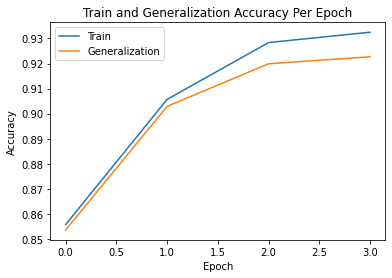

In [9]:
plt.plot(train_acc_list,label='Train')
plt.plot(test_acc_list,label='Generalization')
plt.legend()
plt.title("Train and Generalization Accuracy Per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

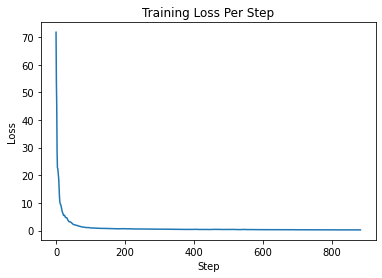

In [10]:
plt.plot(step_loss_list)
plt.title("Training Loss Per Step")
plt.ylabel("Loss")
plt.xlabel("Step")
plt.show()

## Plot delta in training loss compared to Taylor approximation of delta on the step losses

- As a reminder, the loss through the training process can be approximated by the following expression :

$$ L(\theta_{t+1}) - L(\theta_t) \approx \sum_{i=0}^{K-1} (\nabla_\theta L(\theta))^{(i)}* ((\theta_{t+1})^{(i)} - (\theta_t)^{(i)})$$ with the gradient of the loss being decomposed through a RK4 approach.

- Let's examine how the LCA method is relevant by using this expressionn.

(833,)
(833,)


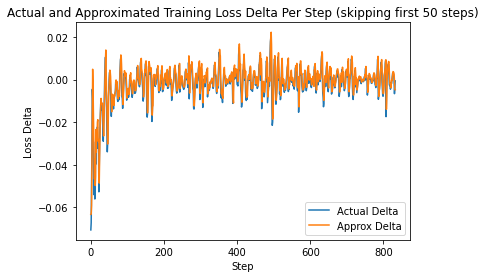

In [11]:
# We skip the first steps as they are quite noisy
skip_step = 50

# We plot the actual delta loss and approximate delta loss (through the LCA method) at each step
training_loss_delta = (np.array(step_loss_list)[1:] - np.array(step_loss_list)[:-1])[skip_step:]
training_loss_delta_approximation = step_lcas_over_time.sum(1)[skip_step:]
print(training_loss_delta.shape)
print(training_loss_delta_approximation.shape)
plt.plot(training_loss_delta,label='Actual Delta')
plt.plot(training_loss_delta_approximation,label='Approx Delta')
plt.legend()
plt.title("Actual and Approximated Training Loss Delta Per Step (skipping first 50 steps)")
plt.ylabel("Loss Delta")
plt.xlabel("Step")
plt.show()

In [12]:
# approximation is highly correlated
np.corrcoef(training_loss_delta, training_loss_delta_approximation)

array([[1.        , 0.88268028],
       [0.88268028, 1.        ]])

The approximation is pretty good, but the model does not fit exactly what was expected (the computed loss is a little higher than the actual loss.

# Visualisation of the LCA process

## View per neuron per timestep

In [13]:
# function which plots the training process of the neurons of a layer over time
def plot_neurons_over_time (nb_iterations, nb_neurons, size_neuron, LCA):
  lca_per_neuron = np.zeros((nb_iterations,nb_neurons))

  for i in range(nb_neurons):
    lca_per_neuron[:,i] = np.sum(LCA[:nb_iterations,i*size_neuron : (i+1)*size_neuron], axis = 1 )
 
  #We normalize the lca in order to print a clean colormap (LCA < 0 appears in green, LCA > 0 appears in red)
  max_lca, min_lca = np.max(lca_per_neuron), -np.min(lca_per_neuron)
  if max_lca > min_lca : 
    norm_factor = min_lca/max_lca
    for i in range(lca_per_neuron.shape[0]):
      for j in range(lca_per_neuron.shape[1]):
        if (lca_per_neuron[i,j] > 0) :
          lca_per_neuron[i,j] *= norm_factor
  else :
    norm_factor = max_lca/min_lca
    for i in range(lca_per_neuron.shape[0]):
      for j in range(lca_per_neuron.shape[1]):
        if (lca_per_neuron[i,j] < 0) :
          lca_per_neuron[i,j] *= norm_factor


  # Dictionary used to create the colormap
  cdict = {'green':   [[0.0,  0.4, 0.4],
                      [0.4,  1.0, 1.0],
                      [0.5,  1.0, 1.0],
                      [1.0,  0.0, 0.0]],
            'red': [[0.0,  0.0, 0.0],
                      [0.5,  1.0, 1.0],
                      [0.6,  1.0, 1.0],
                      [1.0,  0.3, 0.3]],
            'blue':  [[0.0,  0.0, 0.0],
                      [0.5,  1.0, 1.0],
                      [1.0,  0.0, 0.0]]}
  custom_cmap = LinearSegmentedColormap('lc', segmentdata=cdict)

  fig, ax = plt.subplots(figsize=(20,20))
  plt.xlabel('Iterations')
  plt.ylabel('Neurons')
  plt.title(f'Plot of the normalized LCA of {nb_neurons} neurons over {nb_iterations} iterations')

  s = ax.matshow(lca_per_neuron.T, cmap=custom_cmap)
  fig.colorbar(s, label='Normalized LCA per neuron per iteration')
  plt.show()

The neurons hurting the training process (LCA > 0) appear in red, those helping appear in green (LCA < 0).

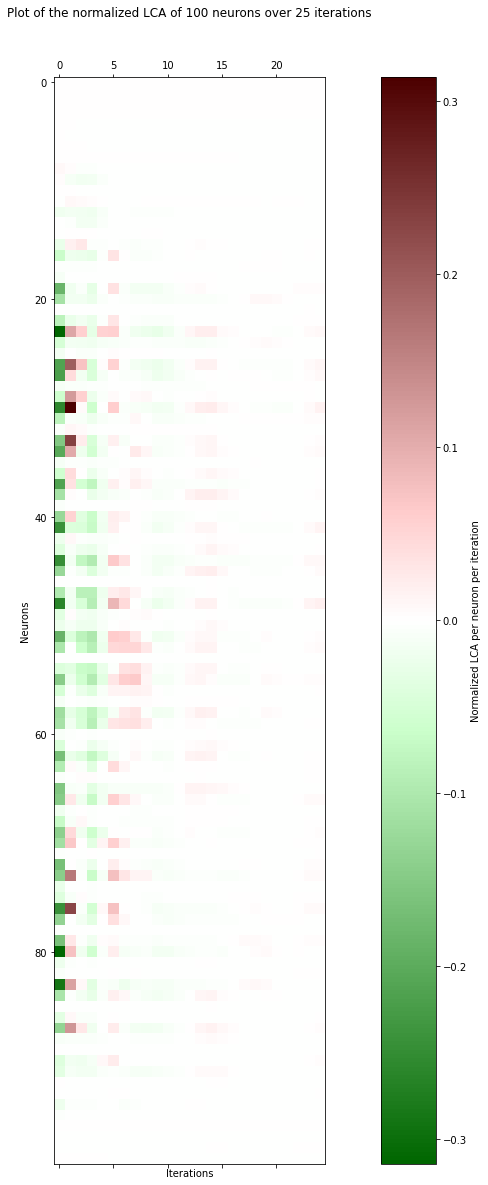

In [14]:
LCA_1=step_lcas[0]

plot_neurons_over_time(25,100, 784, LCA_1)

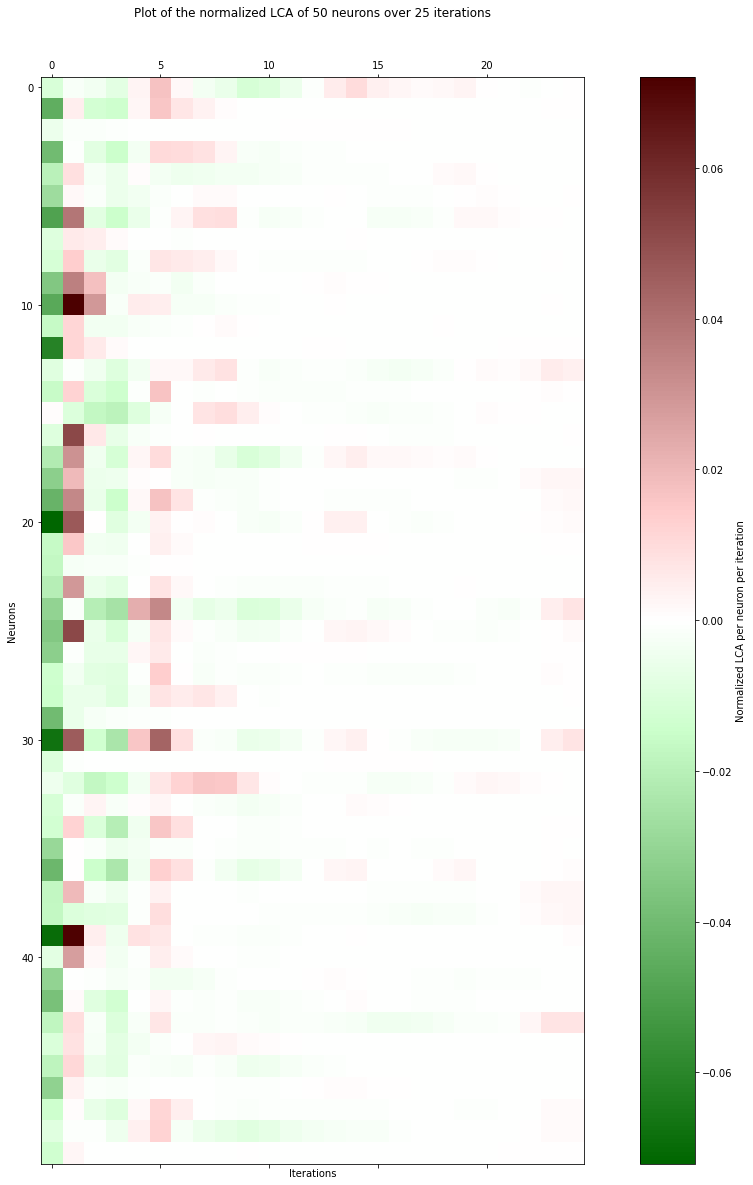

In [15]:
LCA_2 = step_lcas[1]
plot_neurons_over_time(25,50, 100, LCA_2)

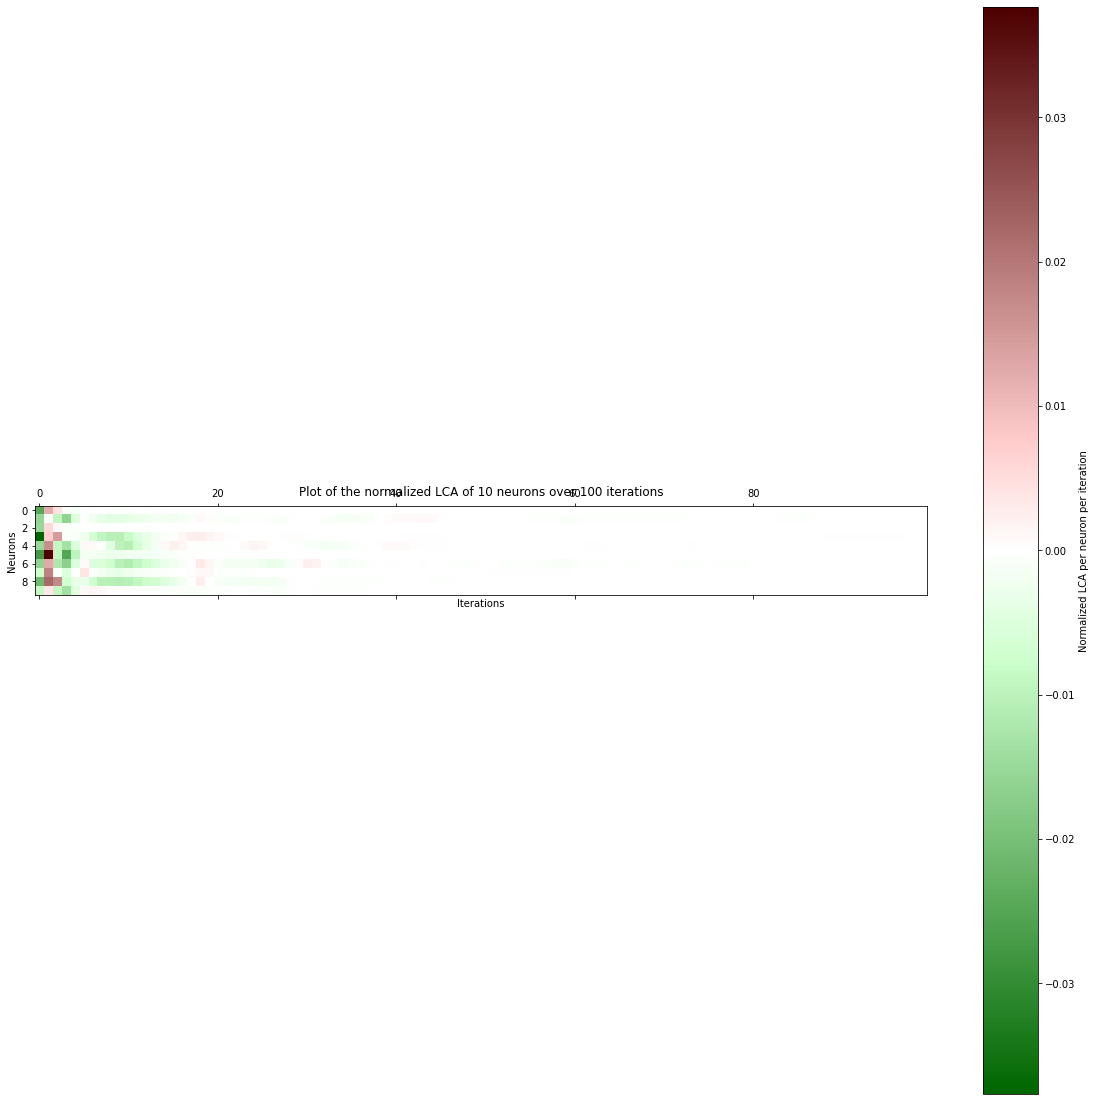

In [16]:
LCA_3 = step_lcas[2]
plot_neurons_over_time(100,10, 50, LCA_3)

We observe few things :
- The neurons learn more during the first iterations
- All the neurons don't participate in the same way in the learning process
- Neurons can alternate between helping and hurting

## Some parameters help more than others in the learning process

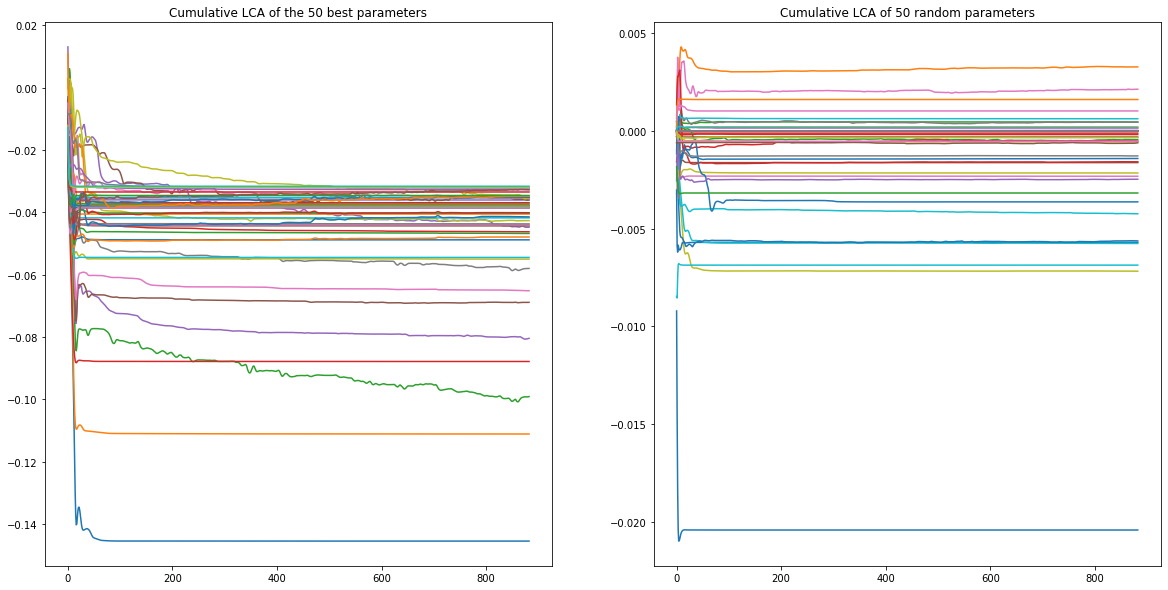

In [17]:
# We compute the cumulative LCA over time for each parameter
cumulative_lca = np.cumsum(step_lcas_over_time, axis = 0)

# define how many parameters will be ploted
num_plot = 50

# we define the best parameters as those having helping the most after all the iterations (which is having the lowest cumulative LCA after all the iterations)
last_step_lcas = cumulative_lca[-1,:]
index_sorted = np.argsort(last_step_lcas)[:num_plot]

index_random = np.random.choice(list(range(step_lcas_over_time.shape[1])), size = num_plot, replace = False)

fig , ax = plt.subplots(1, 2, figsize = (20,10))


ax[0].plot(cumulative_lca[:,index_sorted])
ax[0].set_title(f'Cumulative LCA of the {num_plot} best parameters')
ax[1].plot(cumulative_lca[:, index_random])
ax[1].set_title(f'Cumulative LCA of {num_plot} random parameters')

plt.show()

We remark that :
- all the parameters don't have the same influence on the learning process : some parameters "help" more than others
- a typical parameter's cumulative LCA drops quickly near the beginning and then has a more flatten behavior
- parameters can alternate between helping and hurting from one iteration to the other

# Parameters alternate between helping and hurting

In [18]:
#matrix in which the counts of the switchings of direction will be stored
mean_change_lca = np.zeros(len(step_lcas))

#we examine each layer separetely
for k, step_lca in enumerate(step_lcas):
  change_lca = np.zeros(step_lca.shape[1])

  for j in range(step_lca.shape[1]):
    count_switch_direction = 0
    for i in range(step_lca.shape[0]-1):
      # (step_lca[i,j] * step_lca[i+1, j] < 0) means that for two consecutive iterations, the parameter j have helped one time and hurt the other time
      if step_lca[i,j] * step_lca[i+1, j] < 0 :
        count_switch_direction += 1
    # The number of times the parameter j switches its influence on the learning process is stored in change_lca[j]
    change_lca[j]=count_switch_direction

  mean_change_lca[k] = np.mean(change_lca) # We look at the mean within a layer

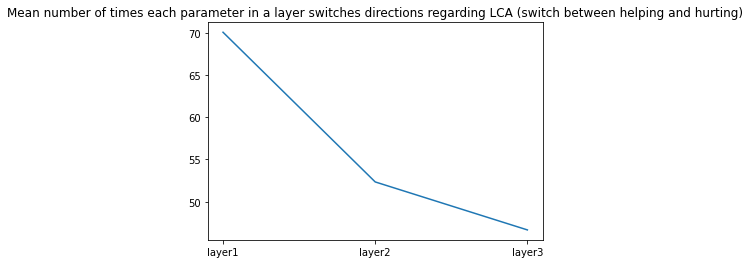

In [19]:
plt.title('Mean number of times each parameter in a layer switches directions regarding LCA (switch between helping and hurting)')
plt.plot(['layer1','layer2','layer3'],mean_change_lca)
plt.show()

Parameters alternate between helping and hurting through the training process

# Influence of each layer on the learning process

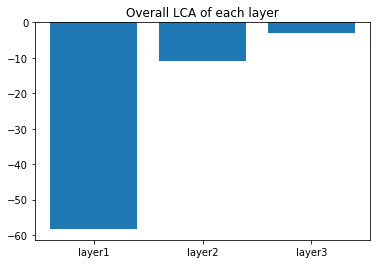

In [20]:
plt.bar(['layer1','layer2','layer3'], [np.sum(step_lca) for step_lca in step_lcas])
plt.title('Overall LCA of each layer')
plt.show()

- Each layer has a different impact on the training process.

- For more complicated networks such as ResNet or AIICNN it is observed that the first and the last layer hurt whereas the other layers help in the process.

# Learning is heavy tailed

As a first approach, one could think that a good model for the distribution of LCA might be a narrow Gaussian around the mean. Instead, the LCA follows a heavy-tailed distribution.

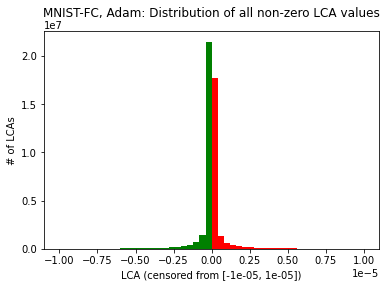

In [21]:
# hist_range = np.quantile(step_lcas_over_time.flatten(),.01), np.quantile(step_lcas_over_time.flatten(),.99)
hist_range = [-1e-5, 1e-5]
plt.hist(step_lcas_over_time.flatten()[step_lcas_over_time.flatten() <0], bins=50, range=hist_range,color='green')
plt.hist(step_lcas_over_time.flatten()[step_lcas_over_time.flatten() >0], bins=50, range=hist_range,color='red')

plt.title('MNIST-FC, Adam: Distribution of all non-zero LCA values',y=1.04)
plt.xlabel(f'LCA (censored from {hist_range})')
plt.ylabel(f'# of LCAs')
plt.show()

# A majority of parameters don't help for the learning in a MNIST learning

In [22]:
# A function which categorizes the percent of helping, hurting parameters as well as the parameters having a zero-effect on the learning process
def categorize_lca(lca) :
    if lca == 0:
        category = 'zero lca'
    elif lca > 0:
        category = 'positive lca'
    else :
      category = 'negative lca'
    return category

# Show the percent of each category of parameters in the neural network
pd.Series(step_lcas_over_time.flatten()).apply(lambda x :categorize_lca(x)).value_counts(normalize=True)

zero lca        0.356029
negative lca    0.350700
positive lca    0.293271
dtype: float64

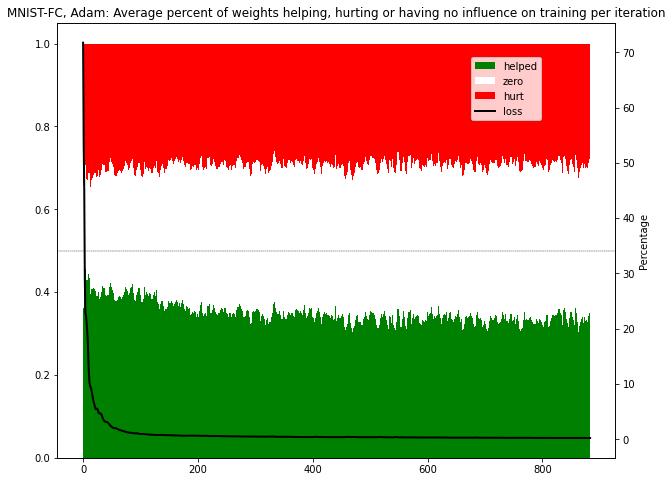

In [23]:
# Initialize with the lenght of the network and the number of iterations
num_steps = step_lcas_over_time.shape[0]
num_weights = step_lcas_over_time.shape[1]

# Enable to get the percent of each category at each timestep
pct_positive_lcas_per_step = np.apply_along_axis(lambda x : (x>0).sum(), 1, step_lcas_over_time) / num_weights  
pct_zero_lcas_per_step = np.apply_along_axis(lambda x : (x==0).sum(), 1, step_lcas_over_time) / num_weights 
pct_negative_lcas_per_step = np.apply_along_axis(lambda x : (x<0).sum(), 1, step_lcas_over_time) / num_weights

ind = np.arange(num_steps)
width = 1

# Plot of the different results
fig, ax1 = plt.subplots(figsize=(10,8))

p1 = ax1.bar(ind, pct_negative_lcas_per_step, width, bottom=0, color='green', label='helped')
p2 = ax1.bar(ind, pct_zero_lcas_per_step, width, bottom=pct_negative_lcas_per_step, color='white', label='zero')
p3 = ax1.bar(ind, pct_positive_lcas_per_step, width, bottom=pct_negative_lcas_per_step+pct_zero_lcas_per_step, color='red', label='hurt')
ax1.axhline(y=.5, xmin=0, xmax=num_steps, c='black',lw=.4,linestyle='--')

ax2 = ax1.twinx()
p0 = ax2.plot(step_loss_list, c='black',lw=2, label='loss')

plt.ylabel('Percentage')
plt.title('MNIST-FC, Adam: Average percent of weights helping, hurting or having no influence on training per iteration')
fig.legend(loc=(.7,.75))

plt.show()



- In a MNIST learning, only about a third of the parameters help (meaning they have a negative LCA).
- A significant percentage of parameters show a zero effect on the learning : they do not have any influence on the training of the network. As some pixels are never on in a MNIST FC network, any layer weights connected to thoise pixel can't help or hurt.

On average, each parameter has helped to decrease the total loss  309.7 times


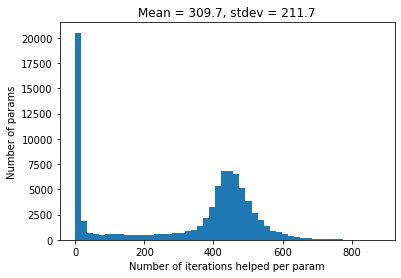

In [24]:
negatives = step_lcas_over_time < 0

iters_per_param = negatives.sum(axis=0)
plt.hist(iters_per_param, bins=50)
plt.xlabel('Number of iterations helped per param')
plt.ylabel('Number of params')
plt.title('Mean = {:.1f}, stdev = {:.1f}'.format(iters_per_param.mean(), iters_per_param.std()))
print('On average, each parameter has helped to decrease the total loss {: .1f} times'.format(iters_per_param.mean()))
plt.show()

As shown previously, an important part of the parameters don't help at all in the learning process (Around 20000 parameters have never helped).

On average, during each iteration, around  29479.9 parameters, over a total of 84060 parameters, help to decrease the overall loss


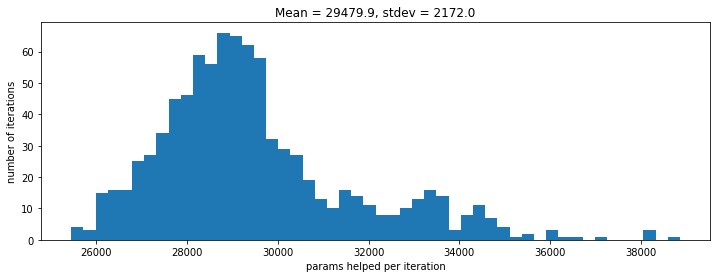

In [25]:
params_per_iter = negatives.sum(axis=1)
plt.figure(figsize=(12, 4))
plt.hist(params_per_iter, bins=50)
plt.xlabel('params helped per iteration')
plt.ylabel('number of iterations')
plt.title('Mean = {:.1f}, stdev = {:.1f}'.format(params_per_iter.mean(), params_per_iter.std()))
print('On average, during each iteration, around {: .1f} parameters, over a total of {} parameters, help to decrease the overall loss'.format(params_per_iter.mean(), step_lcas_over_time.shape[1]))
plt.show()

# CONCLUSION

As a conclusion, the LCA approach has enabled us to study a per parameter per timestep view to better understand the training process. It appears that :
- An important part of the parameters do not help in the training process
- Parameters can alternate between helping and hurting in the training process
- Some parameters contribute a lot to the decrease of the loss

To continue this work it would be possible to :
- implement this notebook with more complex networks (changing the rare parts of the notebook that are not scalable) such as ResNet or AIICNN to observe that for them the first and last layers hurt, meaning they contribute to an increase of the loss whereas all the other layers enable a decrease of the loss
- observe the synchronization of the learning between the layers : all the layers tend to learn during the same iterations to recognize a given digit.